In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from zmapio import ZMAPGrid
import seaborn as sns
import pickle
import collections

In [2]:
df_toc=pd.read_pickle('stage_2_km_hc_clusters.pkl')
df_toc.head(10)

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A,0,1,1
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A,0,1,1
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A,0,1,1
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A,0,1,1
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A,0,1,1
11010.5,ANASAZI `16` STATE 1,3.049,91.310,2.594,68.570,15.906,WC A,0,1,1
11011.0,ANASAZI `16` STATE 1,3.135,97.851,2.594,69.047,16.417,WC A,0,1,1
11011.5,ANASAZI `16` STATE 1,3.202,99.730,2.592,69.521,16.801,WC A,0,1,1
11012.0,ANASAZI `16` STATE 1,3.162,106.253,2.590,69.994,15.508,WC A,0,1,1
11012.5,ANASAZI `16` STATE 1,3.131,110.626,2.586,70.420,14.424,WC A,0,1,1


In [3]:
### convert any pickle fine to csv and save to the folder

df_toc.to_csv('demo.csv')

In [3]:
df_toc['S2']=0
df_toc['TOC']=0
df_toc.head()

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc,S2,TOC
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A,0,1,1,0,0
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A,0,1,1,0,0
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A,0,1,1,0,0
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A,0,1,1,0,0
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A,0,1,1,0,0


In [46]:
df_toc.to_pickle('stage_2_data_for_toc_calc.pkl')

In [4]:
a=np.unique(df_toc['WELL'])

In [5]:
## visualizing sonic and resistivity together

def plot_toc(data, name):
    well=data.loc[data['WELL']==name]
    print('number of samples in well %s :'%name, len(well))
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax2.twiny() #Twins the y-axis for the density track with the neutron track

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)

    # Gamma Ray track

    ax1.plot(well["GRWS"].values, well.index, color = "green", linewidth = 2)
    ax1.set_xlabel("GR (API units)")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth", fontsize=14)
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    ## Sonic track

    ax2.plot(well["DTWS"], well.index, color = "blue", linewidth = 2)
    ax2.set_xlabel("Sonic (μsec/ft)")
    ax2.set_xlim(200, 0)
    ax2.xaxis.label.set_color("blue")
    ax2.tick_params(axis='x', colors="blue")
    ax2.spines["top"].set_edgecolor("blue")
    ax2.set_xticks([200, 150, 100, 50, 0])

    # Resistivity track--- on top of sonic

    ax5.plot(well["DRESWS"], well.index, color = "red", linewidth = 2)
    ax5.set_xlabel("Resistivity - Deep (ohm-m)")
    ax5.set_xlim(0.01, 100)
    ax5.xaxis.label.set_color("red")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.tick_params(axis='x', colors="red")
    ax5.spines["top"].set_edgecolor("red")
    ax5.set_xticks([0.01, 0.1, 1, 10, 100])
    ax5.semilogx()

    ## S2 track

    ax3.plot(well["S2"], well.index, color = "purple", linewidth = 2)
    ax3.set_xlabel(r'$S_{2}(gHC/g)$')
    ax3.set_xlim(0, 50)
    ax3.xaxis.label.set_color("purple")
    ax3.tick_params(axis='x', colors="purple")
    ax3.spines["top"].set_edgecolor("purple")

    ## TOC track

    ax4.plot(well["TOC"], well.index, color = "black", linewidth = 2)
    ax4.set_xlabel("TOC (wt %)")
    ax4.set_xlim(0, 10)
    ax4.xaxis.label.set_color("black")
    ax4.tick_params(axis='x', colors="black")
    ax4.spines["top"].set_edgecolor("black")

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(well.index.min(), well.index.max())
        ax.tick_params(labelsize=12)
        ax.grid(which='major', color='black', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2, ax3, ax4]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    #ax.set_title("%s"%name, fontsize=16, loc='center')
    ax.annotate('%s'%name, xy=(-1.5, 1.2), xycoords='axes fraction', size=16)
    fig.subplots_adjust(wspace = 0.15)
    plt.show()
    

In [6]:
## demo
plot_toc(data, 'TYRRELL W C UNIT 1 4')

NameError: name 'data' is not defined

In [41]:
## LOM data for the 31 wells in the wolfcamp interval A

df_lom=pd.read_csv('31_WELL_COORDS.csv', index_col=0)
df_lom.head()

,Well Name,UWI,Surf X,Surf Y,VR_WC_A.dat,VR_WC_B.dat,Average,LOM,Unnamed: 9,TR-B_WC_A.dat,TR-DE_WC_DE.dat,Unnamed: 12,Data
6.0,PRICE ESTATE UNIT 1 3,4.24E+13,2280607.0,11267636.3,0.867221,0.899344,0.883283,9.275141,NaN,65.612930,37.259293,NaN,Well-log
80.0,TYRRELL W C UNIT 1 4,4.24E+13,2277136.9,11272178.5,0.868515,0.902157,0.885336,9.284070,NaN,65.807854,37.496563,NaN,Well-log
173.0,SCHLOSSER FRED ESTA 2-D,4.24E+13,2209224.3,11298339.1,0.845814,0.869848,0.857831,9.164483,NaN,62.097412,33.171295,NaN,Well-log
188.0,UNIVERSITY 20-5 1,4.23E+13,2152070.6,11524191.5,1.079001,1.125022,1.102011,10.115581,NaN,81.879173,61.720505,NaN,Well-log
308.0,UNIVERSITY 10-18 `A 7,4.25E+13,2181957.9,11482911.2,0.958597,1.013910,0.986254,9.722841,NaN,75.401596,50.622520,NaN,Well-log


In [11]:
df_lom=df_lom[['Well Name', 'LOM']]
#df_lom=df_lom.dropna(inplace=True)

In [13]:
df_lom=df_lom.dropna()

In [14]:
df_lom

,Well Name,LOM
6.0,PRICE ESTATE UNIT 1 3,9.275141
80.0,TYRRELL W C UNIT 1 4,9.284070
173.0,SCHLOSSER FRED ESTA 2-D,9.164483
188.0,UNIVERSITY 20-5 1,10.115581
308.0,UNIVERSITY 10-18 `A 7,9.722841
309.0,UNIVERSITY 11-18 `A 5,9.700128
328.0,UNIVERSITY 20-16 1,10.065899
330.0,UNIVERSITY 17-18 1H,9.665328
331.0,REEVES `BG` FEE 2,9.362698
429.0,UNIVERSITY 16-18 `B 1,9.567161


In [16]:
data=pd.read_pickle('stage_2_data_for_toc_calc.pkl')
data

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc,S2,TOC,LOM
11032.0,ANASAZI `16` STATE 1,3.126,121.460,2.559,71.500,27.214,WC A,1,1,1,0,0,9.847191
11032.5,ANASAZI `16` STATE 1,3.133,129.964,2.559,71.500,27.328,WC A,1,1,1,0,0,9.847191
11033.0,ANASAZI `16` STATE 1,3.083,125.979,2.564,70.897,27.443,WC A,1,1,1,0,0,9.847191
11035.5,ANASAZI `16` STATE 1,2.880,122.580,2.561,70.167,31.931,WC A,1,1,1,0,0,9.847191
11036.0,ANASAZI `16` STATE 1,2.867,121.702,2.551,70.799,31.931,WC A,1,1,1,0,0,9.847191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785.5,WHITE CITY UNIT COM 2,3.743,116.898,2.603,85.066,6.199,WC A,1,1,1,0,0,10.131248
8786.0,WHITE CITY UNIT COM 2,3.861,114.825,2.608,84.000,6.509,WC A,1,1,1,0,0,10.131248
8795.5,WHITE CITY UNIT COM 2,3.723,114.131,2.617,83.369,6.268,WC A,1,1,1,0,0,10.131248
8796.0,WHITE CITY UNIT COM 2,3.697,113.658,2.611,84.140,6.131,WC A,1,1,1,0,0,10.131248


In [16]:
data=df_toc

In [18]:
for i in range(len(data)):
    data['LOM'].iloc[i]=df_lom['LOM'].loc[df_lom['Well Name']==data['WELL'].iloc[i]].values


/scratch/user/eliza95/.conda/envs/elsaenv/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
data.head()

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc,S2,TOC,LOM
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A,0,1,1,0,0,9.847191
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A,0,1,1,0,0,9.847191
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A,0,1,1,0,0,9.847191
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A,0,1,1,0,0,9.847191
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A,0,1,1,0,0,9.847191


In [20]:
data.to_pickle('stage_2_data_for_toc_calc.pkl')

## TOC calculation

In [21]:
data['dlogR']=0
data.head()

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc,S2,TOC,LOM,dlogR
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A,0,1,1,0,0,9.847191,0
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A,0,1,1,0,0,9.847191,0
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A,0,1,1,0,0,9.847191,0
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A,0,1,1,0,0,9.847191,0
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A,0,1,1,0,0,9.847191,0


In [36]:
np.sum(data['DRESWS']>1000)

1

In [22]:
## defining the parameters

Rbase=7
dtbase=70

data['dlogR']=np.log10((data['DRESWS'])/Rbase) + 0.02*(data['DTWS'] - dtbase)


In [23]:
data['TOC']= data['dlogR']*(10**(2.297-0.1688*data['LOM']))

In [24]:
data['S2']=((0.1028*data['LOM']**4 - 3.94*data['LOM']**3 + 50.4*data['LOM']**2 - 290*data['LOM'] + 960) * data['TOC'])/100

In [25]:
data

,WELL,PEFWS,GRWS,DENWS,DTWS,DRESWS,Interval,facies_km,facies_hc,facies_sc,S2,TOC,LOM,dlogR
11008.0,ANASAZI `16` STATE 1,2.865,103.895,2.594,68.471,15.191,WC A,0,1,1,2.585085,1.319427,9.847191,0.305908
11008.5,ANASAZI `16` STATE 1,2.809,98.146,2.595,67.866,14.876,WC A,0,1,1,2.405933,1.227988,9.847191,0.284708
11009.0,ANASAZI `16` STATE 1,2.764,93.175,2.598,67.542,14.776,WC A,0,1,1,2.326419,1.187404,9.847191,0.275299
11009.5,ANASAZI `16` STATE 1,2.820,87.963,2.601,67.714,15.113,WC A,0,1,1,2.438252,1.244483,9.847191,0.288533
11010.0,ANASAZI `16` STATE 1,2.938,86.100,2.597,68.097,15.504,WC A,0,1,1,2.596725,1.325368,9.847191,0.307286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794.5,WHITE CITY UNIT COM 2,3.796,108.610,2.622,82.344,6.037,WC A,0,1,1,1.276287,0.705267,10.131248,0.182603
8795.0,WHITE CITY UNIT COM 2,3.753,112.532,2.622,82.870,6.225,WC A,0,1,1,1.442902,0.797337,10.131248,0.206441
8795.5,WHITE CITY UNIT COM 2,3.723,114.131,2.617,83.369,6.268,WC A,1,1,1,1.533552,0.847430,10.131248,0.219411
8796.0,WHITE CITY UNIT COM 2,3.697,113.658,2.611,84.140,6.131,WC A,1,1,1,1.574247,0.869917,10.131248,0.225233


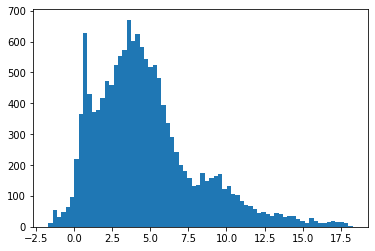

In [26]:
plt.hist(data['TOC'].values, bins=70)
plt.show()

number of samples in well ANASAZI `16` STATE 1 : 666


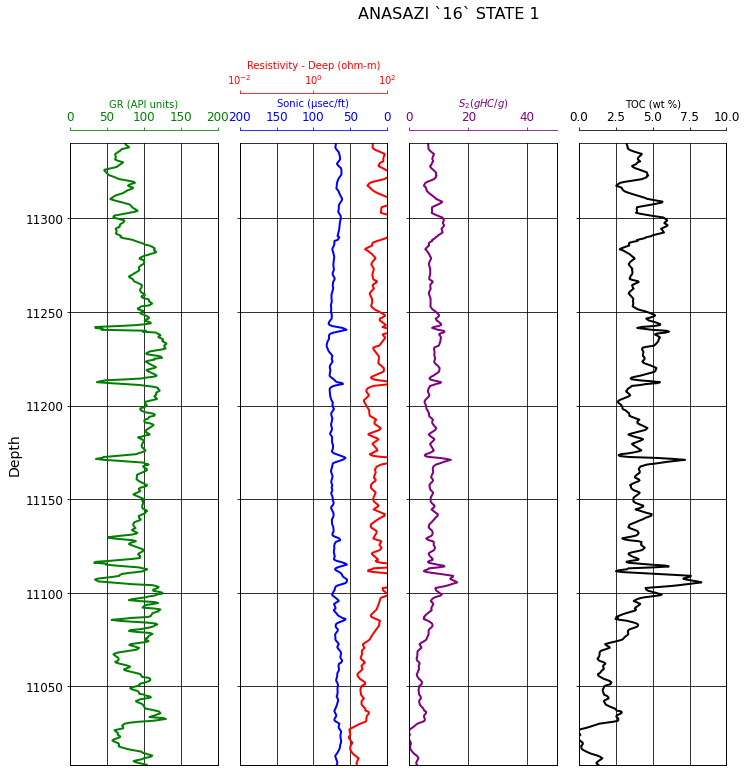

number of samples in well ANGUS 7 STATE 1 : 646


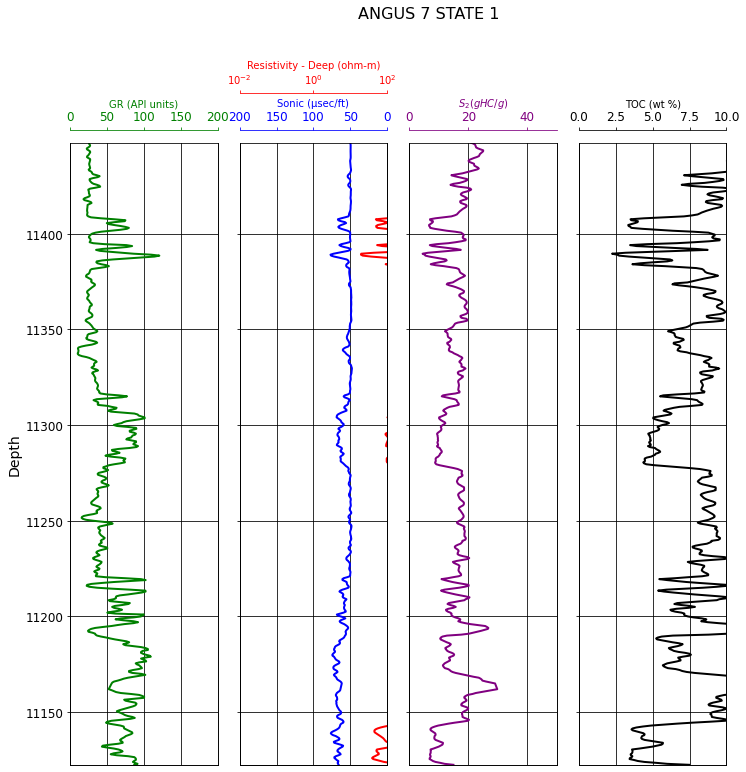

number of samples in well BILBREY `32` STATE 1 : 739


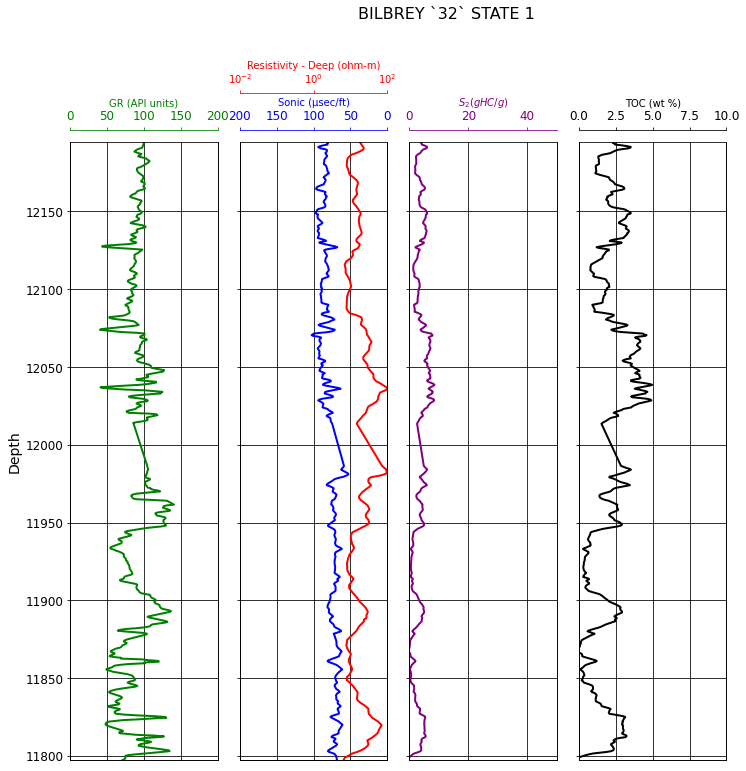

number of samples in well BOUNDS 25 COM 1 : 157


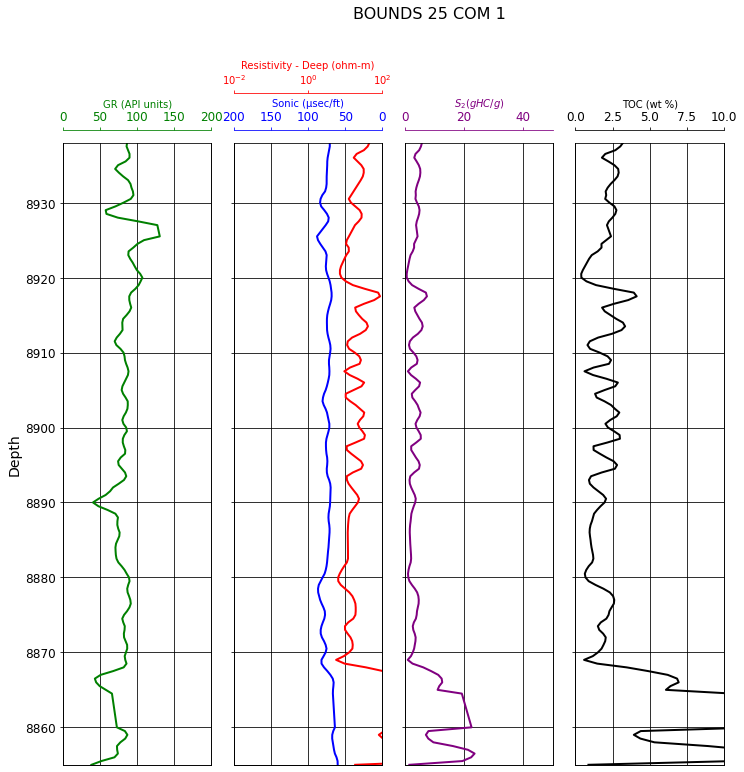

number of samples in well COTTON DRAW `9L` FE 1 : 357


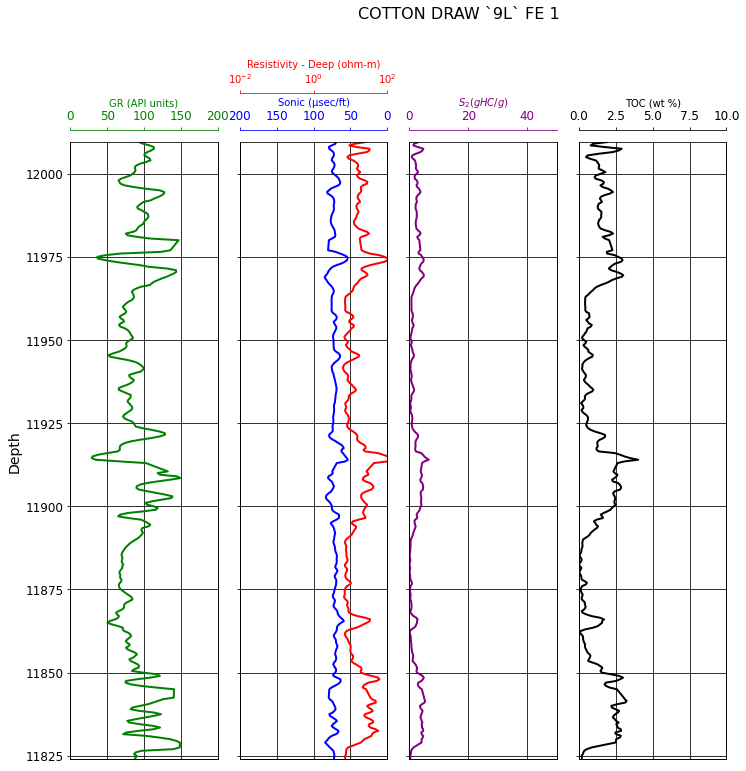

number of samples in well GERONIMO 28 STATE C 1 : 934


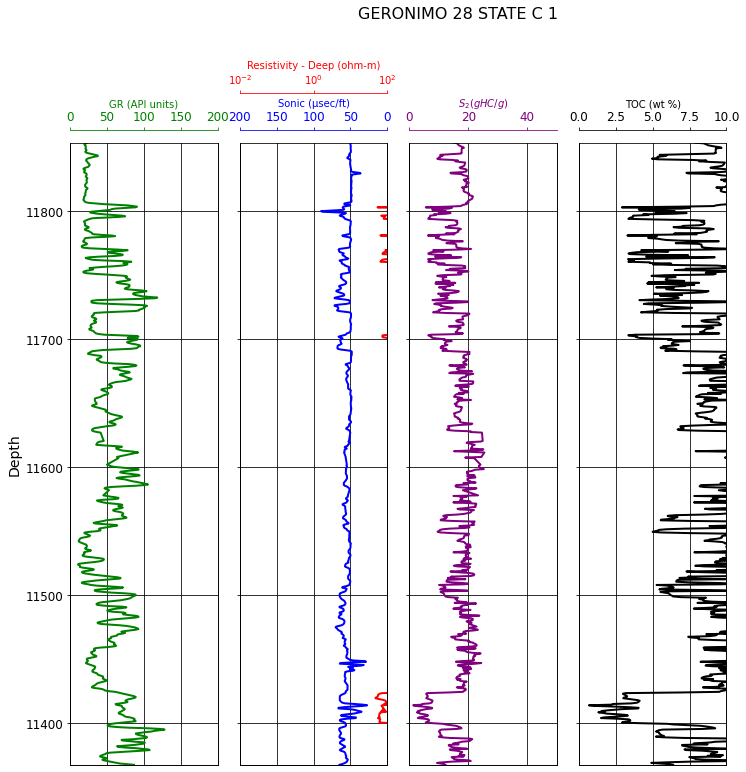

number of samples in well GURNEY 3 STATE 1 : 307


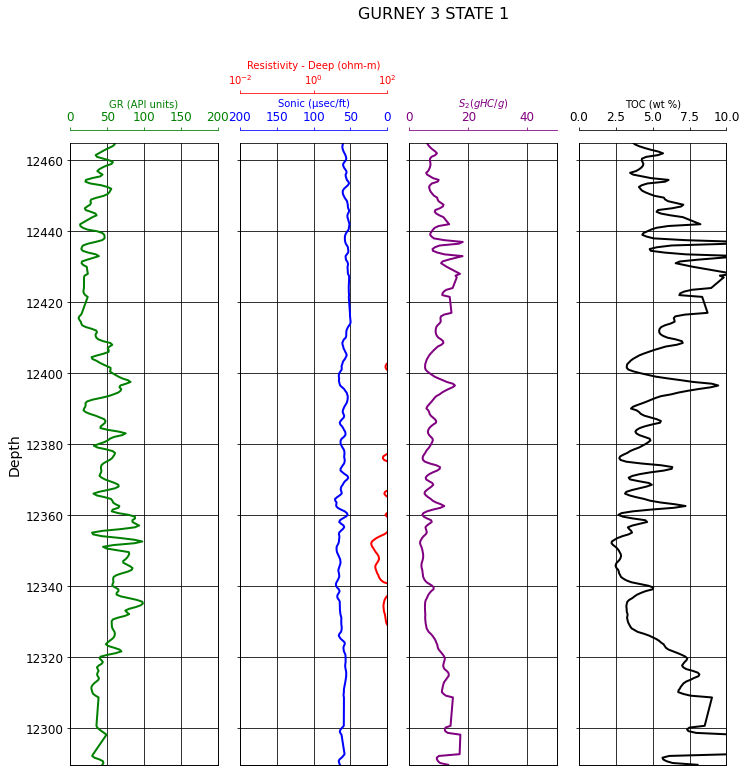

number of samples in well LANCASTER SPRING UN 3 : 660


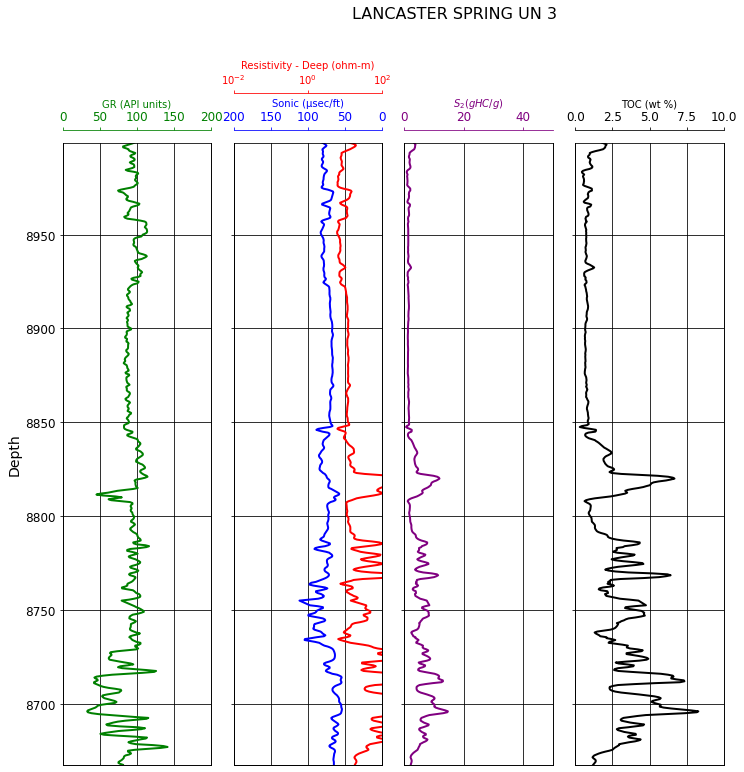

number of samples in well MADERA 24 FEDERAL 1 : 735


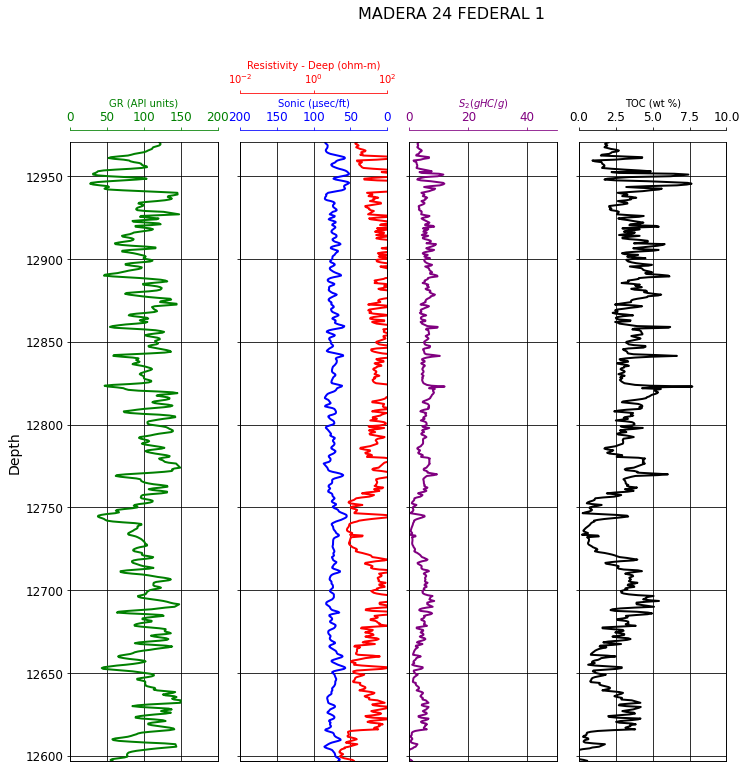

number of samples in well MERCHANT 8 FEDERAL 1 : 422


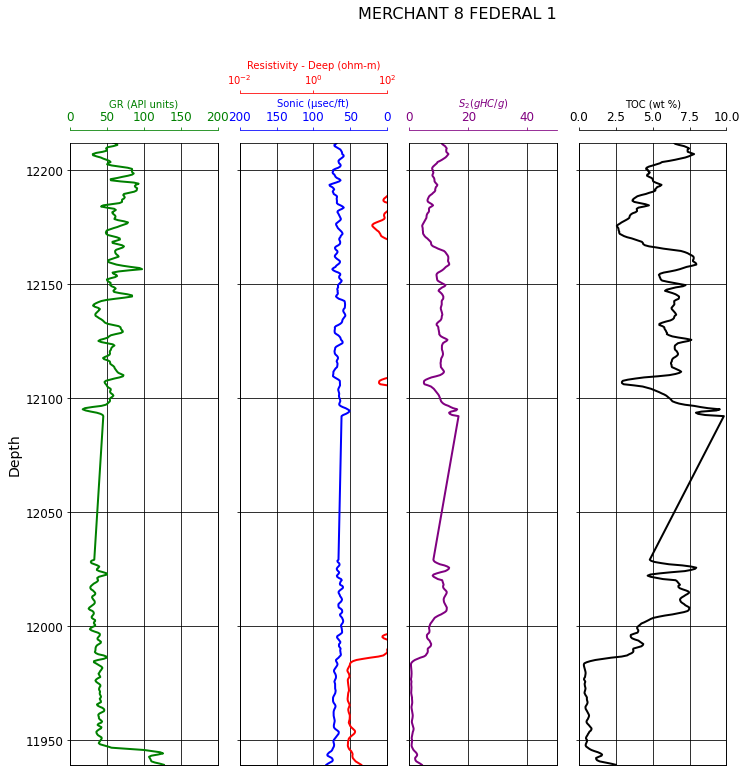

number of samples in well MILLARD DECK ESTATE 1 : 1463


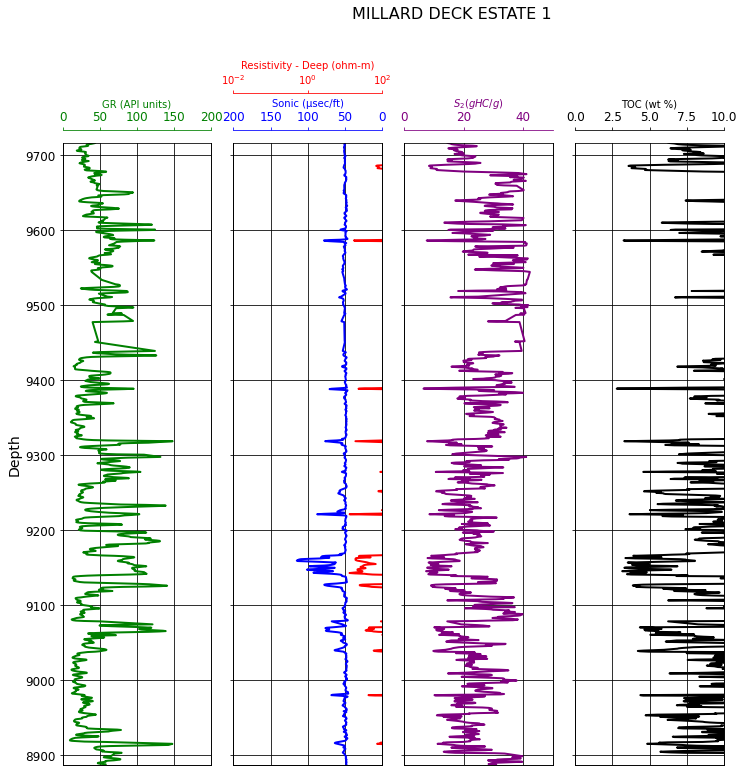

number of samples in well MURCHINSON `2` STAT 1 : 146


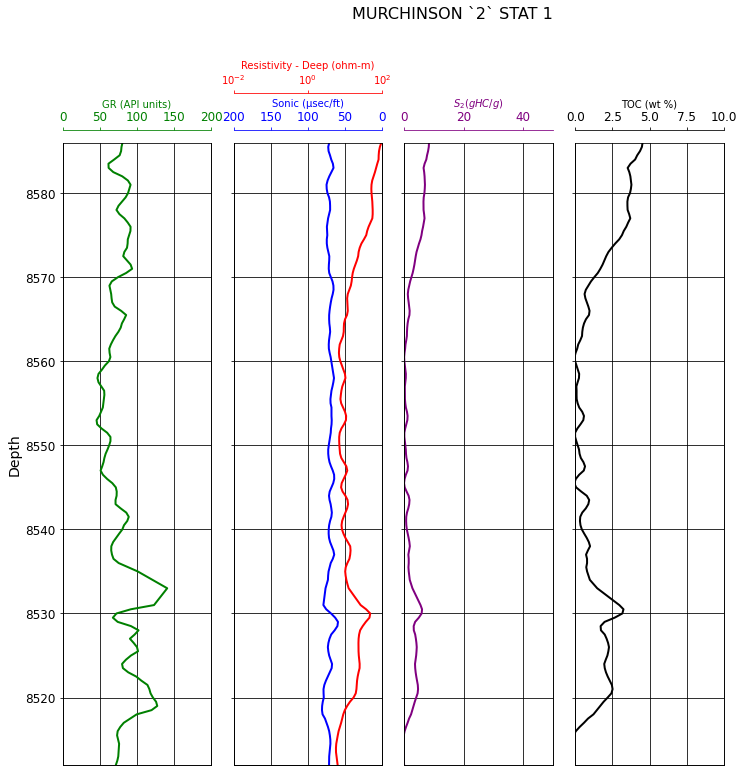

number of samples in well PALOMA 30 FEDERAL 2 : 826


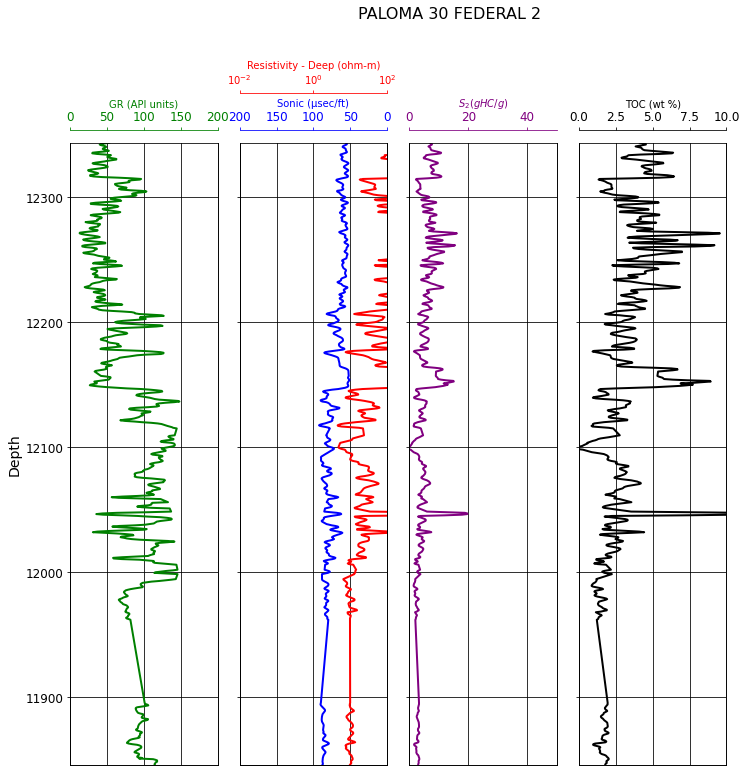

number of samples in well PLU BIG SINKS 11 FE 1H PILOT : 473


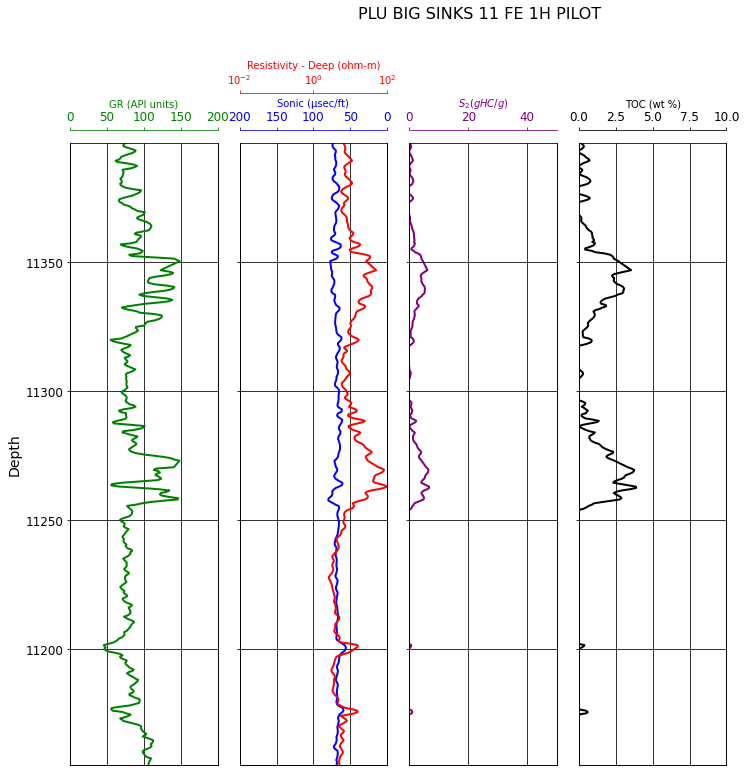

number of samples in well PRICE ESTATE UNIT 1 3 : 707


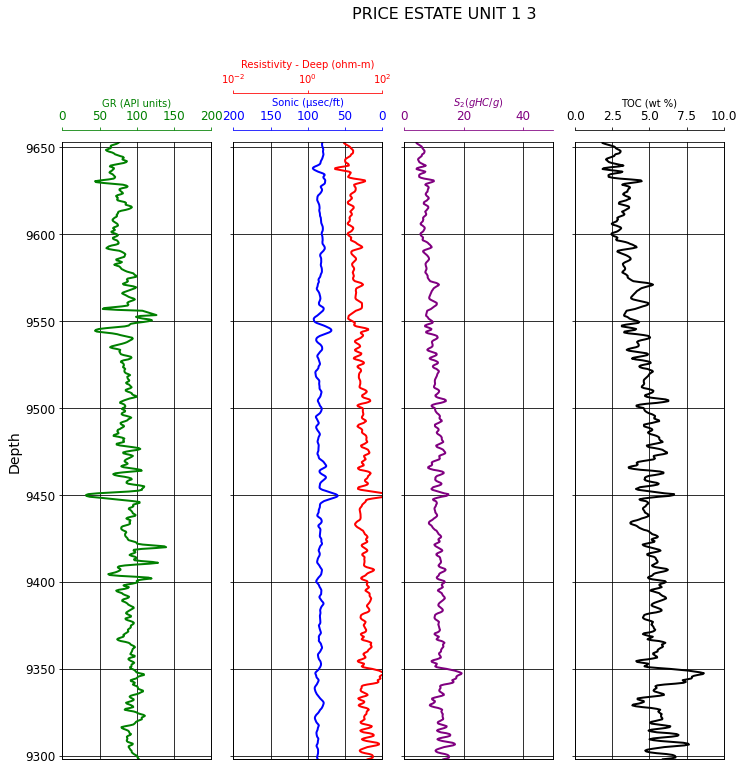

number of samples in well SCHLOSSER FRED ESTA 2-D : 547


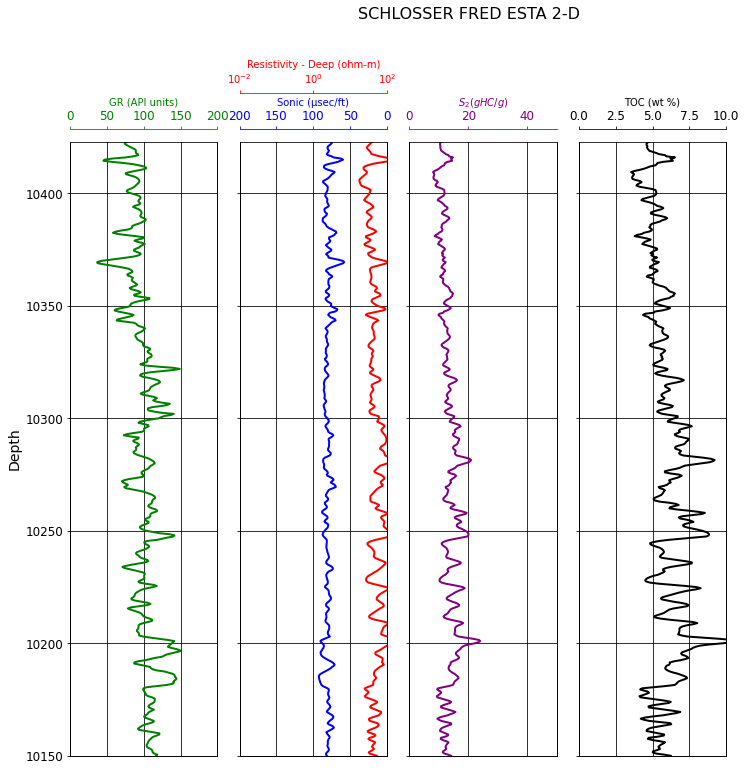

number of samples in well TYRRELL W C UNIT 1 4 : 683


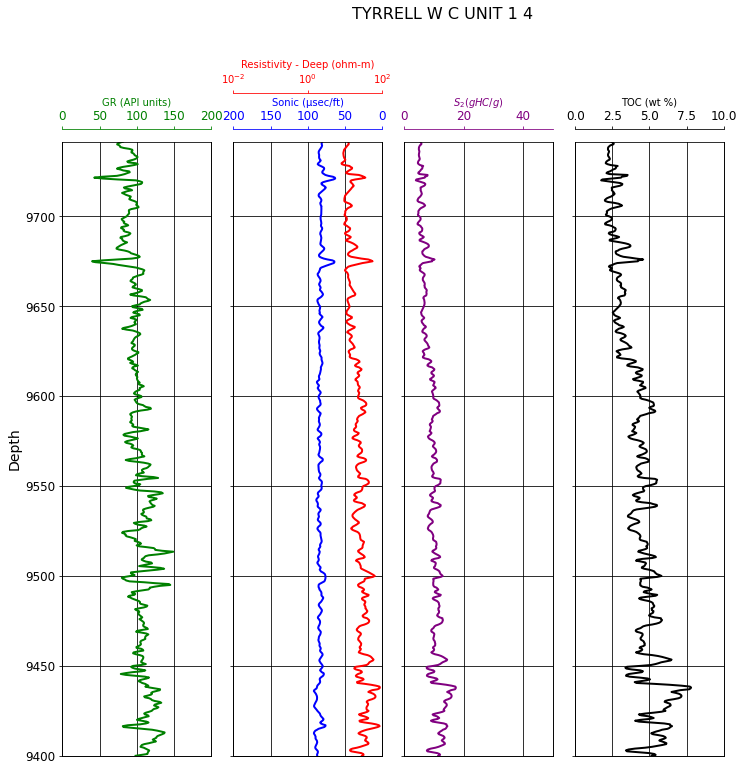

number of samples in well UNIVERSITY 10-18 `A 7 : 40


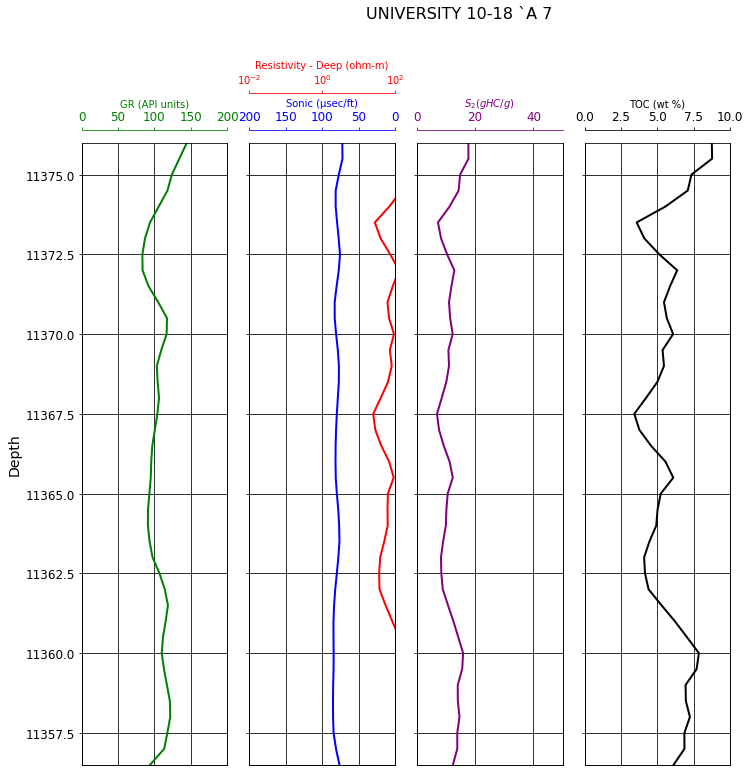

number of samples in well UNIVERSITY 11-18 `A 5 : 63


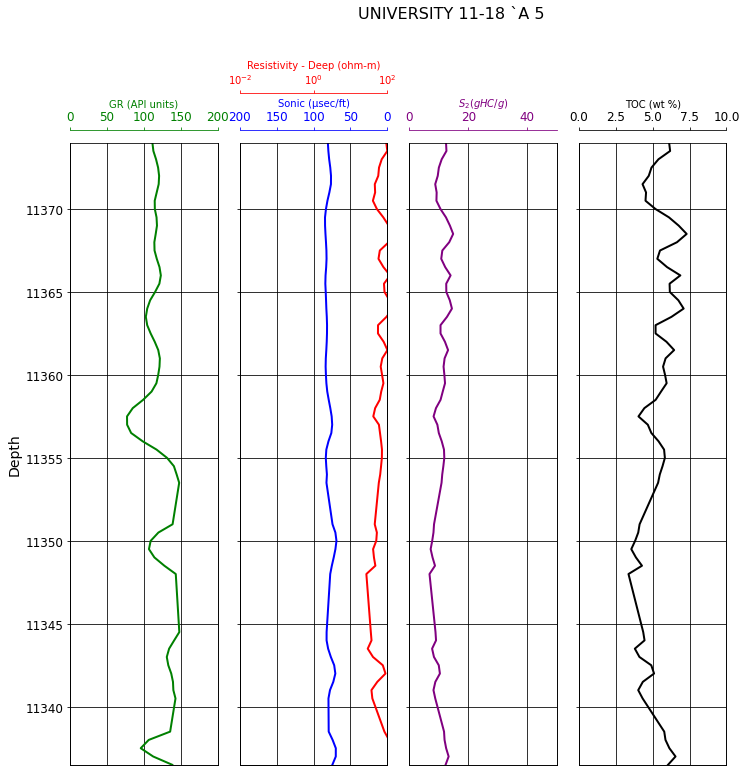

number of samples in well UNIVERSITY 16-18 `A 1 : 589


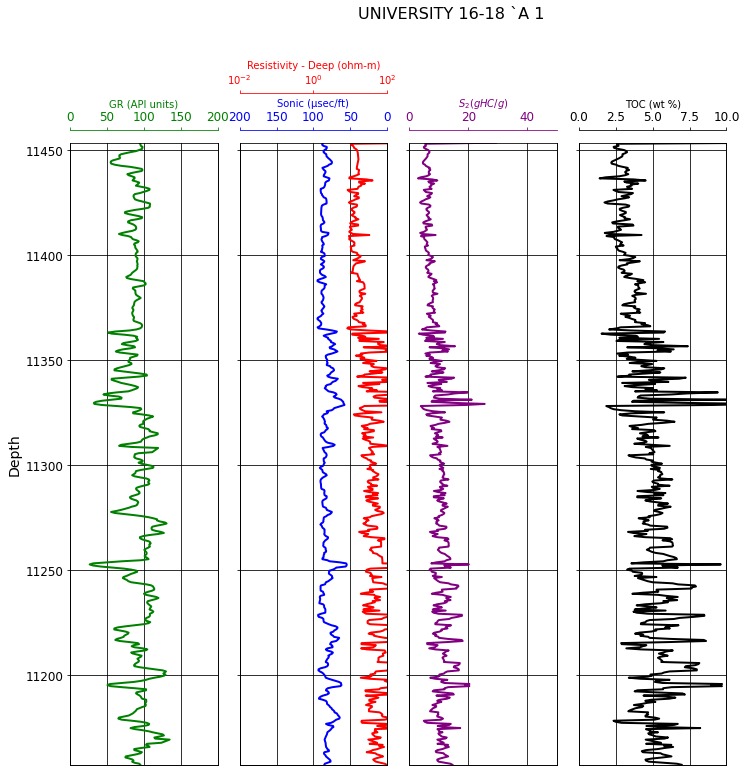

number of samples in well UNIVERSITY 16-18 `B 1 : 526


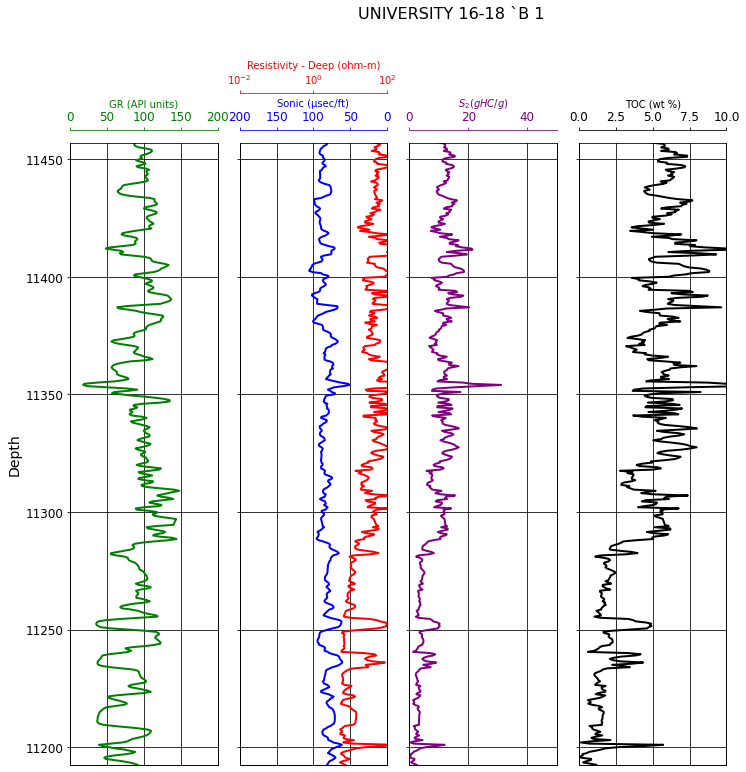

number of samples in well UNIVERSITY 17-18 1H : 610


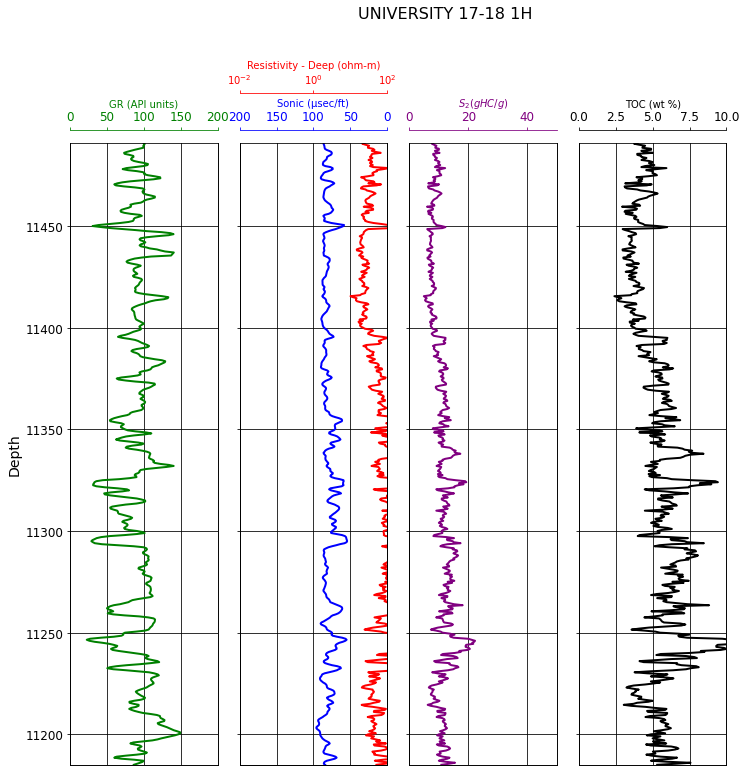

number of samples in well UNIVERSITY 20-16 1 : 714


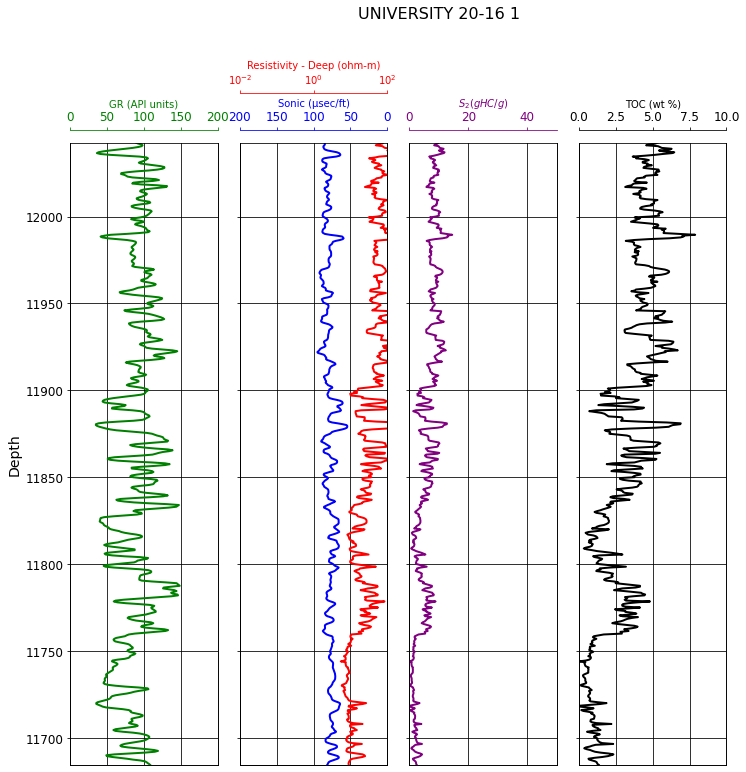

number of samples in well UNIVERSITY 20-5 1 : 718


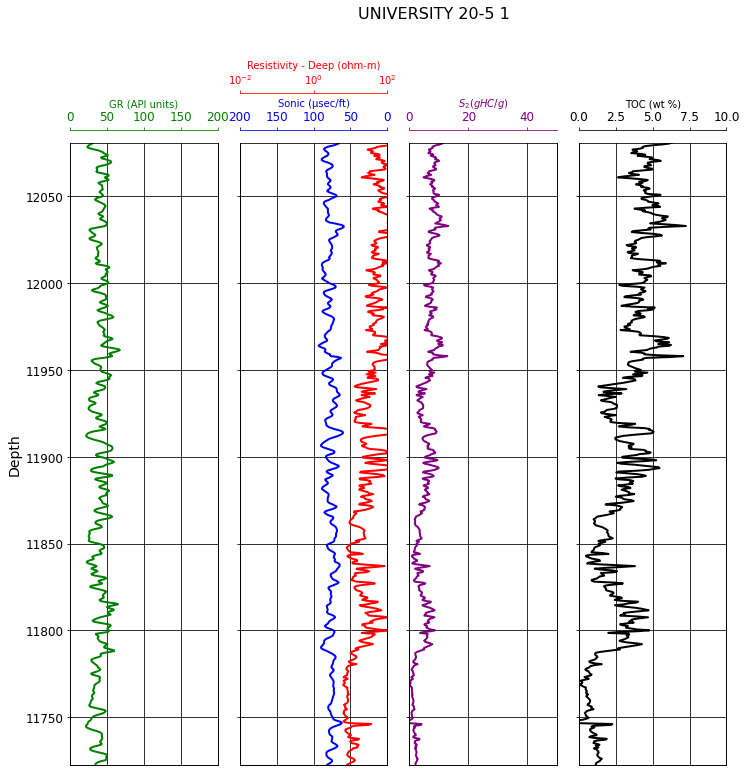

number of samples in well WHITE CITY UNIT COM 2 : 711


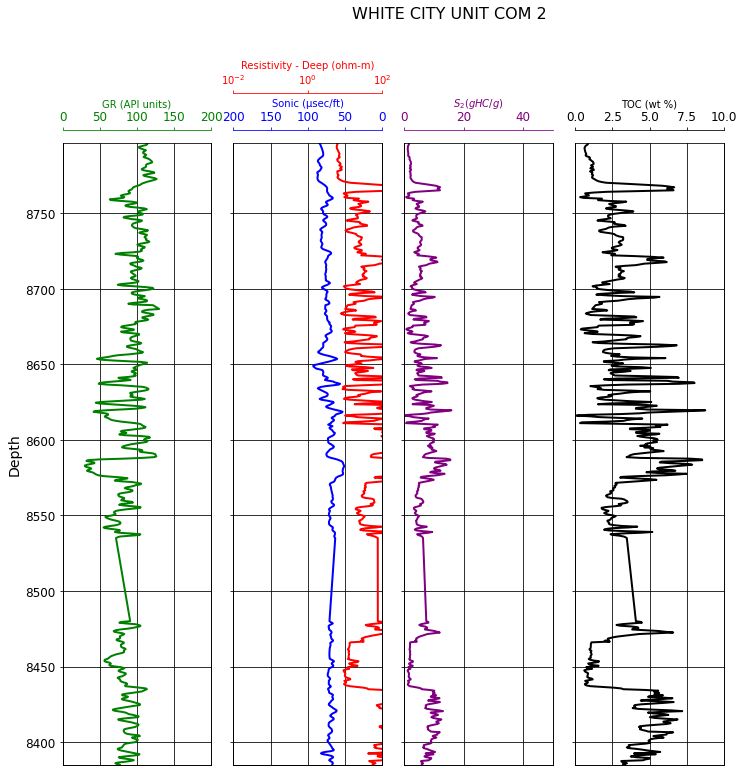

In [27]:
## displaying all the wells

for name in np.unique(data['WELL']):
    plot_toc(data, name)

In [28]:
data.to_pickle('stage_2_toc_s2_data.pkl')

In [30]:
p=np.percentile(data['TOC'], [10,50,90])

In [31]:
p[0]

0.8471334599302598

## TOC distribution across the basin

In [32]:
import mplcursors
%matplotlib nbagg

In [38]:
top_map=ZMAPGrid('New-Wolfcamp_A.dat')

In [47]:
p10=data['WELL'].loc[data['TOC']<=p[0]].values
p50=data['WELL'].loc[data['TOC']<=p[1]].values
p90=data['WELL'].loc[data['TOC']<=p[2]].values


In [48]:
len(p10), len(p50), len(p90)

(1444, 7220, 12995)

<IPython.core.display.Javascript object>


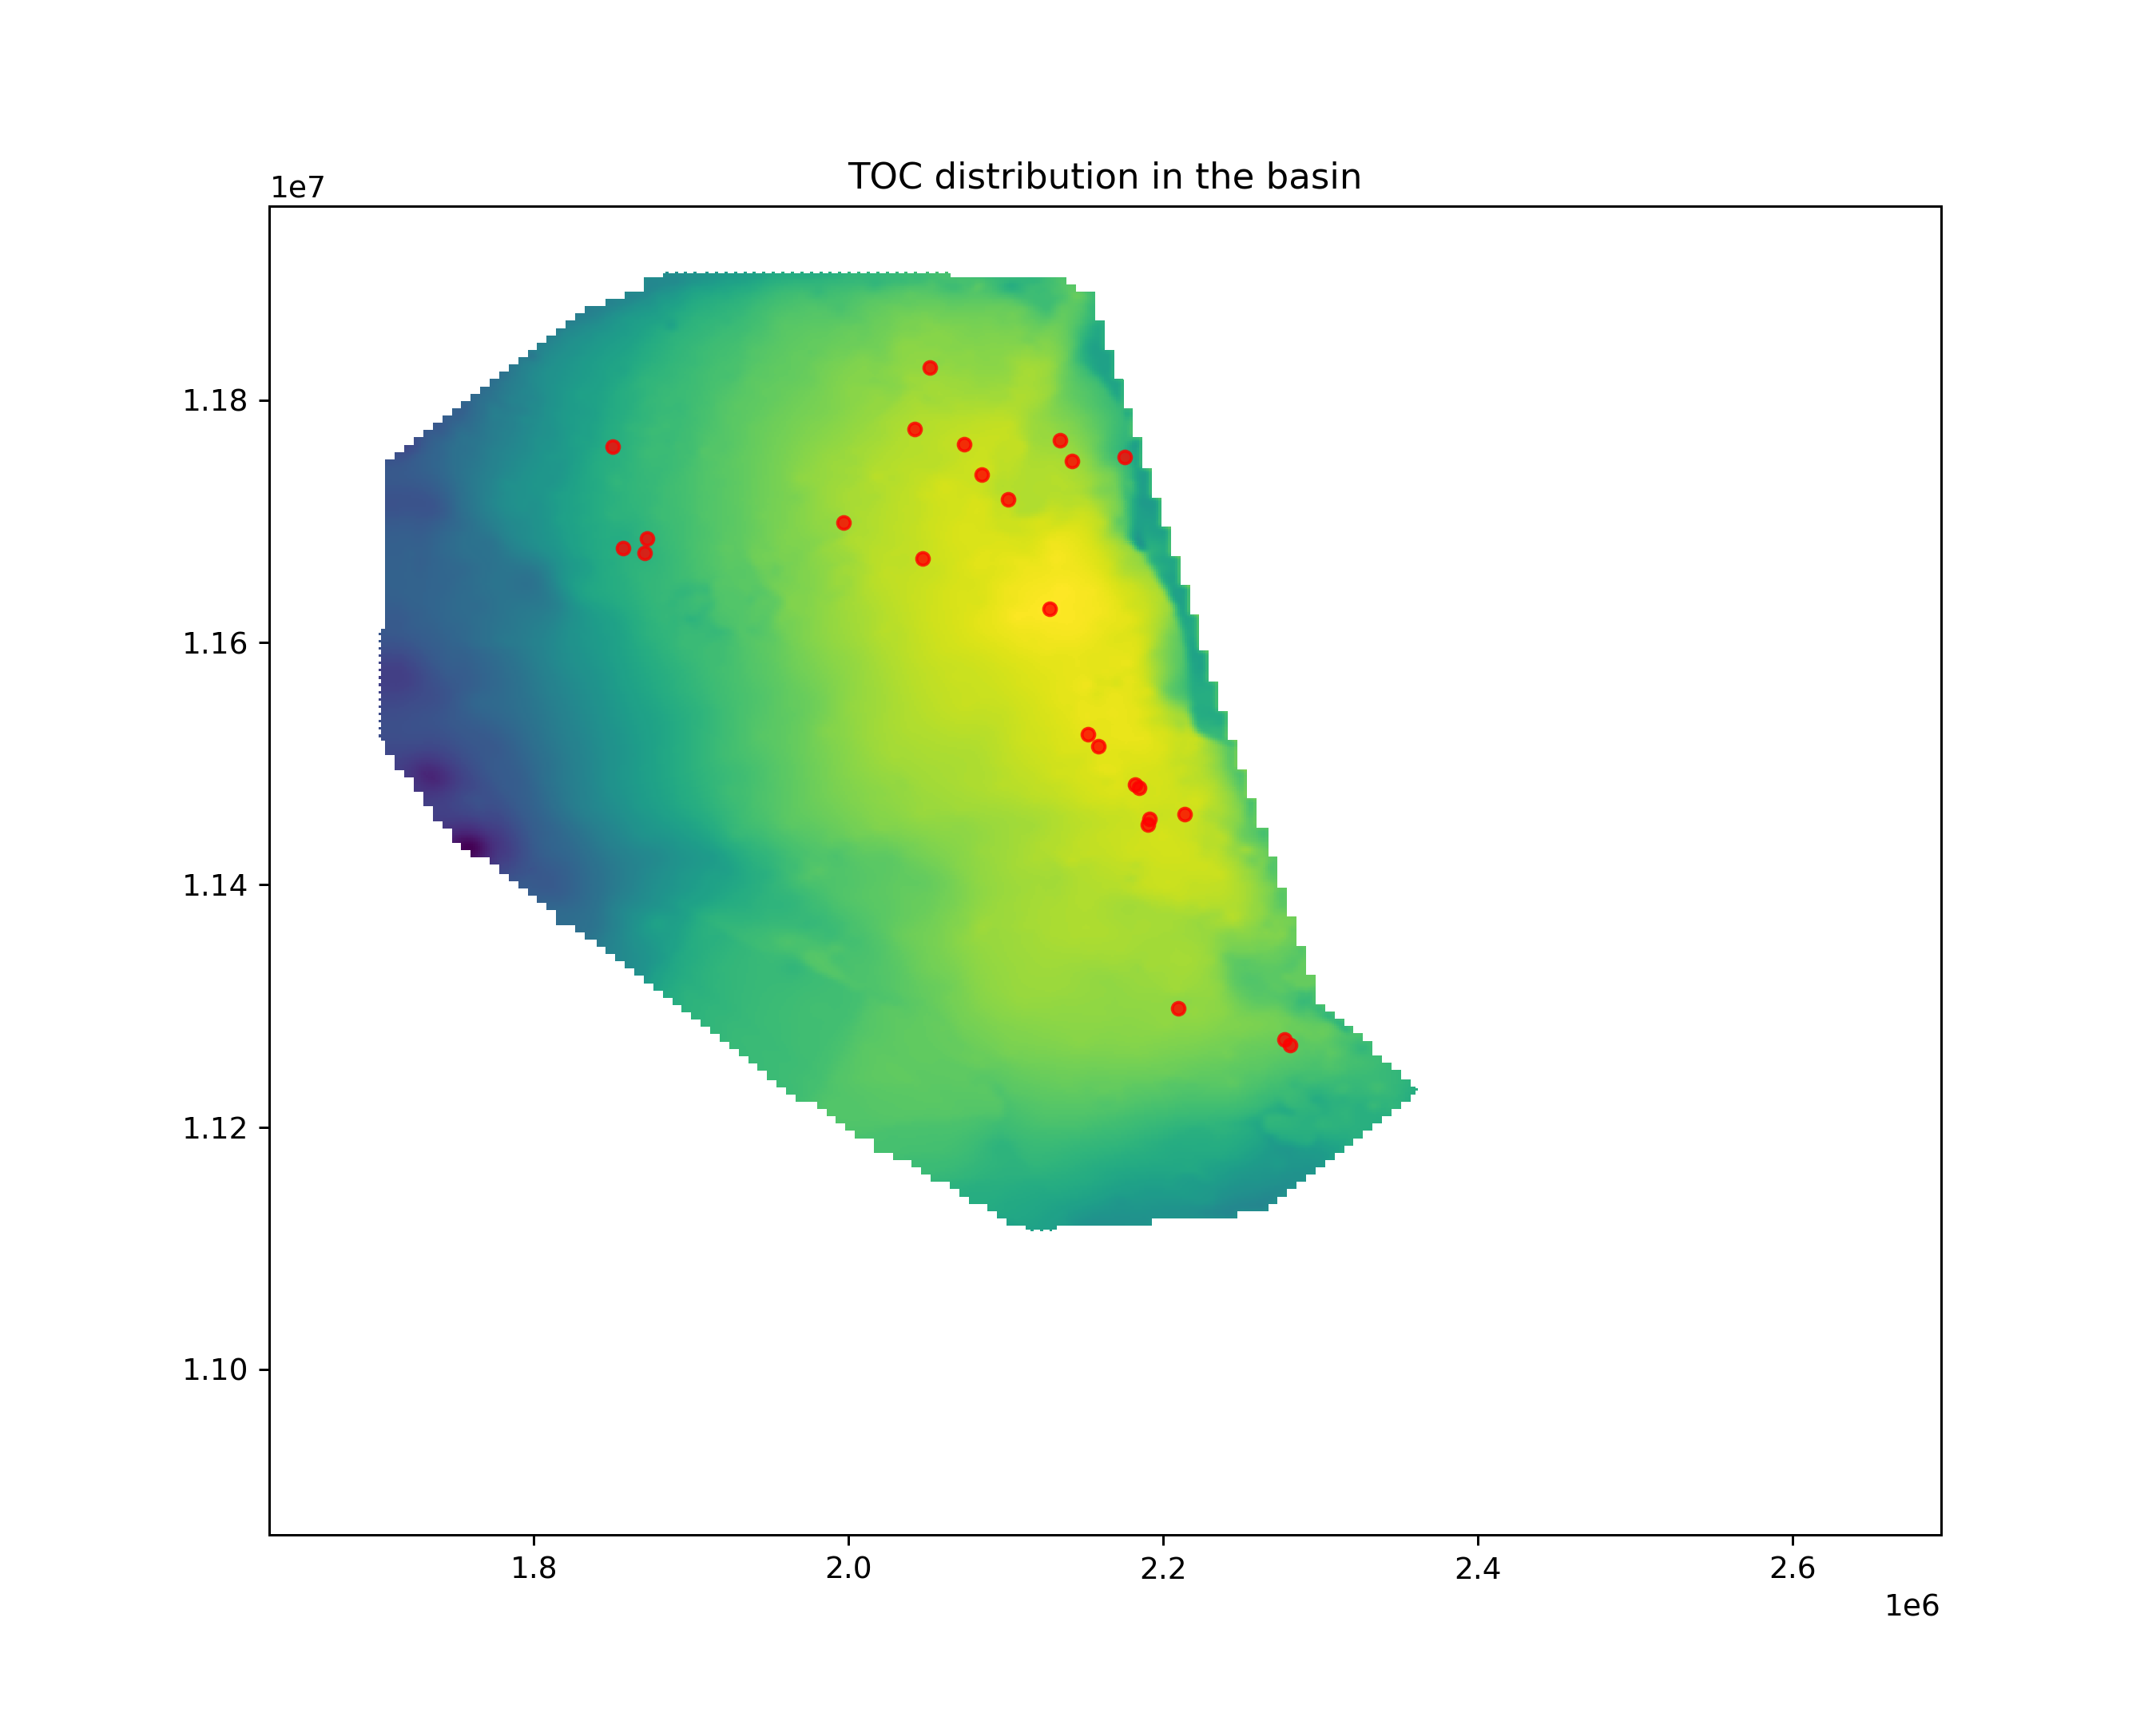

In [43]:
fig, ax = plt.subplots(figsize = (10,8))
top_map.plot()
df1=df_lom.loc[df_lom['Well Name'].isin(p1)]
df1=df.loc[df['TOC']]
ax.scatter(df['Surf X'], df['Surf Y'], zorder=1, 
           alpha= 0.8, c='r', s=18)
ax.set_title('TOC distribution in the basin')
labels=df['Well Name'].values
mplcursors.cursor(ax, hover=True).connect(
    "add", lambda sel: sel.annotation.set_text(labels[sel.target.index]))
plt.show()

In [44]:
len(a)

25